In [1]:
# %pip install ipywidgets

In [2]:
# !jupyter nbextension enable --py widgetsnbextension

In [3]:
from typing import *

import logging
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

### Board, game logic

In [4]:
SUITES = {
    0: '♣',
    1: '♦',
    2: '♥',
    3: '♠'
}

In [5]:
FACES = {
    v-2: str(v) for v in range(2,11)
}
FACES[9] = 'J'
FACES[10] = 'Q'
FACES[11] = 'K'
FACES[12] = 'A'

In [6]:
class Card:
    def __init__(self, card_id: Optional[int] = None):
        self.id = card_id if card_id is not None else random.randint(0, 51)

    def get_id(self):
        return self.id

    def get_value(self):
        
        value = 2 + self.id % 13
        if value == 13:
            value 
        return value

    def get_suite(self):
        return self.id // 13
    
    def get_face(self):
        return self.id % 13

    def get_value(self):
        if self.get_face() == 12:
            return 11
        return min(10, 2 + self.get_face())

    def __repr__(self) -> str:
        return FACES[self.id % 13] + SUITES[self.id // 13]
    
    @staticmethod
    def random(self) -> "Card":
        return Card(random.randint(0, 51))

In [7]:
# deck = []
# for i in range(52):
#     card = Card(i)
#     deck.append(card)

In [8]:
# deck_pd = pd.DataFrame([
#     {'id': card.get_id(), 'suite': card.get_suite(), 'face': card.get_face(), 'value': card.get_value(), 'rep': card} for card in deck
# ]).set_index('id')
# deck_pd

In [9]:
class Hand:
    def __init__(self, *cards):
        self.cards = list(cards)
        self.usable_ace = False
        self.value = None
        self._update()

    def _update(self):
        aces = 0
        value = 0
        for card in self.cards:
            value += card.get_value()
            if card.get_value() == 11:
                aces += 1
        if aces > 0:
            if value > 21:
                value -= 10 # count one ace as 1
                aces -= 1
        
        self.value = value
        self.usable_ace = aces > 0

    def add(self, card: Card):
        self.cards.append(card)
        self._update()

    def has_usable_ace(self):
        return self.usable_ace
    
    def get_value(self):
        return self.value

    def __repr__(self):
        return "[%s]=%s" % ((",".join(map(str, self.cards))), self.get_value())
    
    def __len__(self):
        return len(self.cards)

In [10]:
h = Hand(Card(12), Card(25), Card(38))
h

[A♣,A♦,A♥]=23

In [11]:
h = Hand(Card(12), Card(0), Card(13), Card(26), Card(28), Card(33))
h

[A♣,2♣,2♦,2♥,4♥,9♥]=20

In [12]:
h.has_usable_ace()

False

In [244]:
from dataclasses import dataclass
from enum import Enum

class Game:
    class Step(Enum):
        IDLE = "idle"
        STARTED = "started"
        FINISHED = "finished"

    def __init__(self, seed = None, dealer_card: Optional[Card] = None, player_hand: Optional[Hand] = None, delay_start: bool = False):
        self.seed = random.randint(0, 2**32-1) if seed is None else seed
        random.seed(self.seed)
        np.random.seed(self.seed)
        self.step = Game.Step.IDLE
        self.reward = None
        self.dealer = Hand(dealer_card) if dealer_card else Hand(Card())
        if player_hand and len(player_hand.cards) > 2:
            raise RuntimeError("Invalid initialization hand")
        self.player = player_hand if player_hand else Hand()
        while len(self.player) < 2:
            self.player.add(Card())
        if not delay_start:
            self.start()
    
    def start(self) -> "Game":
        if self.step != Game.Step.IDLE:
            raise RuntimeError("Invalid action")
        self.step = Game.Step.STARTED
        if self.player.get_value() == 21:
            self.dealer.add(Card())
            if self.dealer.get_value() == 21:
                self._draw()
            else:
                self._win()
        return self

    def _finish(self, reward: int):
        self.step = Game.Step.FINISHED
        self.reward = reward

    def _win(self):
        self._finish(reward=1)
    
    def _draw(self):
        self._finish(reward=0)
    
    def _lose(self):
        self._finish(reward=-1)

    def get_state(self) -> Dict[str, Any]:
        result = {'seed': self.seed, 'step': self.step}
        result['dealer'] = self.dealer
        result['player'] = self.player
        if self.reward is not None:
            result['reward'] = self.reward
        return result

    def is_finished(self) -> bool:
        return self.step == Game.Step.FINISHED

    def get_reward(self) -> int:
        if self.step != Game.Step.FINISHED:
            raise RuntimeError("Game is not finished yet")
        return self.reward

    def hit(self) -> "Game":
        if self.step != Game.Step.STARTED:
            raise RuntimeError("Invalid action")
        self.player.add(Card())
        if self.player.get_value() > 21:
            self._lose()
        return self
    
    def stick(self) -> "Game":
        if self.step != Game.Step.STARTED:
            raise RuntimeError("Invalid action")

        while self.dealer.get_value() < 17:
            self.dealer.add(Card())
        
        if self.dealer.get_value() > 21:
            self._win()
        elif self.dealer.get_value() < self.player.get_value():
            self._win()
        elif self.dealer.get_value() > self.player.get_value():
            self._lose()
        else:
            self._draw()
        return self

    def __repr__(self):
        return str(self.get_state())

In [172]:
Game()

{'seed': 519605348, 'step': <Step.STARTED: 'started'>, 'dealer': [K♣]=10, 'player': [J♣,8♣]=18}

In [173]:
Game(809289762)

{'seed': 809289762, 'step': <Step.STARTED: 'started'>, 'dealer': [Q♠]=10, 'player': [2♥,9♠]=11}

In [174]:
Game(809289762).stick()

{'seed': 809289762, 'step': <Step.FINISHED: 'finished'>, 'dealer': [Q♠,K♣]=20, 'player': [2♥,9♠]=11, 'reward': -1}

In [175]:
Game(809289762).hit()

{'seed': 809289762, 'step': <Step.STARTED: 'started'>, 'dealer': [Q♠]=10, 'player': [2♥,9♠,K♣]=21}

In [176]:
Game(809289762).hit().stick()

{'seed': 809289762, 'step': <Step.FINISHED: 'finished'>, 'dealer': [Q♠,6♣,10♣]=26, 'player': [2♥,9♠,K♣]=21, 'reward': 1}

In [177]:
Game(dealer_card=Card(12), player_hand=Hand(Card(25), Card(24)))

{'seed': 1014215201, 'step': <Step.FINISHED: 'finished'>, 'dealer': [A♣,9♥]=20, 'player': [A♦,K♦]=21, 'reward': 1}

In [178]:
Game(seed=201771888, dealer_card=Card(12), player_hand=Hand(Card(25), Card(24)))

{'seed': 201771888, 'step': <Step.FINISHED: 'finished'>, 'dealer': [A♣,3♠]=14, 'player': [A♦,K♦]=21, 'reward': 1}

In [179]:
Game(seed=201771888, dealer_card=Card(12), player_hand=Hand(Card(25), Card(24)), delay_start=True)

{'seed': 201771888, 'step': <Step.IDLE: 'idle'>, 'dealer': [A♣]=11, 'player': [A♦,K♦]=21}

In [180]:
Game(seed=201771888, dealer_card=Card(12), player_hand=Hand(Card(25), Card(24)), delay_start=True).start()

{'seed': 201771888, 'step': <Step.FINISHED: 'finished'>, 'dealer': [A♣,3♠]=14, 'player': [A♦,K♦]=21, 'reward': 1}

In [181]:
Game(seed=2770671493, dealer_card=Card(12), player_hand=Hand(Card(25), Card(24)))

{'seed': 2770671493, 'step': <Step.FINISHED: 'finished'>, 'dealer': [A♣,K♣]=21, 'player': [A♦,K♦]=21, 'reward': 0}

### Policy end evaluation framework

In [182]:
class HitUntilPolicy:
    def __init__(self, min_value=20):
        self.min_value = min_value

    def play(self, game: Game):
        while not game.is_finished():
            if game.get_state()['player'].get_value() >= self.min_value:
                game.stick()
            else:
                game.hit()


In [183]:
p = HitUntilPolicy()

In [184]:
g = Game(2598249481)
p.play(g)
g

{'seed': 2598249481, 'step': <Step.FINISHED: 'finished'>, 'dealer': [9♥,A♦]=20, 'player': [Q♥,6♠,2♠,2♣]=20, 'reward': 0}

In [185]:
g = Game()
p.play(g)
g

{'seed': 3792117417, 'step': <Step.FINISHED: 'finished'>, 'dealer': [J♥,4♣,5♠]=19, 'player': [J♥,3♦,8♥]=21, 'reward': 1}

### Approximate state values:

In [186]:
import collections

In [272]:
def get_state_key(game: Game):
    return (game.dealer.get_value(), game.player.get_value(), game.player.has_usable_ace())

In [273]:
def exploring_starts_eval(policy_name, policy, iterations=100):
    state_values = collections.defaultdict(collections.Counter)
    pbar = tqdm.tqdm(total=13*13*13*iterations, desc=f"evaluating {policy_name}...")
    for dcard in range(13):
        for pcard1 in range(13):
            for pcard2 in range(13):
                for _ in range(iterations):
                    game = Game(dealer_card=Card(dcard), player_hand=Hand(Card(pcard1), Card(pcard2)), delay_start=True)
                    state_key = get_state_key(game)
                    policy.play(game.start())
                    state_values[state_key]['episodes'] += 1
                    state_values[state_key]['reward'] += game.get_reward()
                    pbar.update(1)
    pbar.close()
    return state_values

In [274]:
policy_stats = {}
for min_value in range(14, 21):
    policy_name = f"min{min_value}"
    policy_stats[policy_name] = exploring_starts_eval(policy_name, HitUntilPolicy(min_value=min_value))

evaluating min14...:   0%|          | 0/219700 [00:00<?, ?it/s]

evaluating min15...:   0%|          | 0/219700 [00:00<?, ?it/s]

evaluating min16...:   0%|          | 0/219700 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [191]:
# results = []
# for policy_name, stats in policy_stats.items():
#     for (dv, pv, ua), info in stats.items():
#         results.append({
#             'policy': policy_name, 
#             'dealer_value': dv, 
#             'player_value': pv, 
#             'usable_ace': bool(ua), 
#             'episodes': info['episodes'], 
#             'reward': info['reward']
#         })

# results = pd.DataFrame(results)
# results.to_csv("./chapter-05-blackjack-results.tsv", sep="\t", index=False)
# results

This is how the surface for various state values look like for the strategy min17, across all states including ones with usable ace:

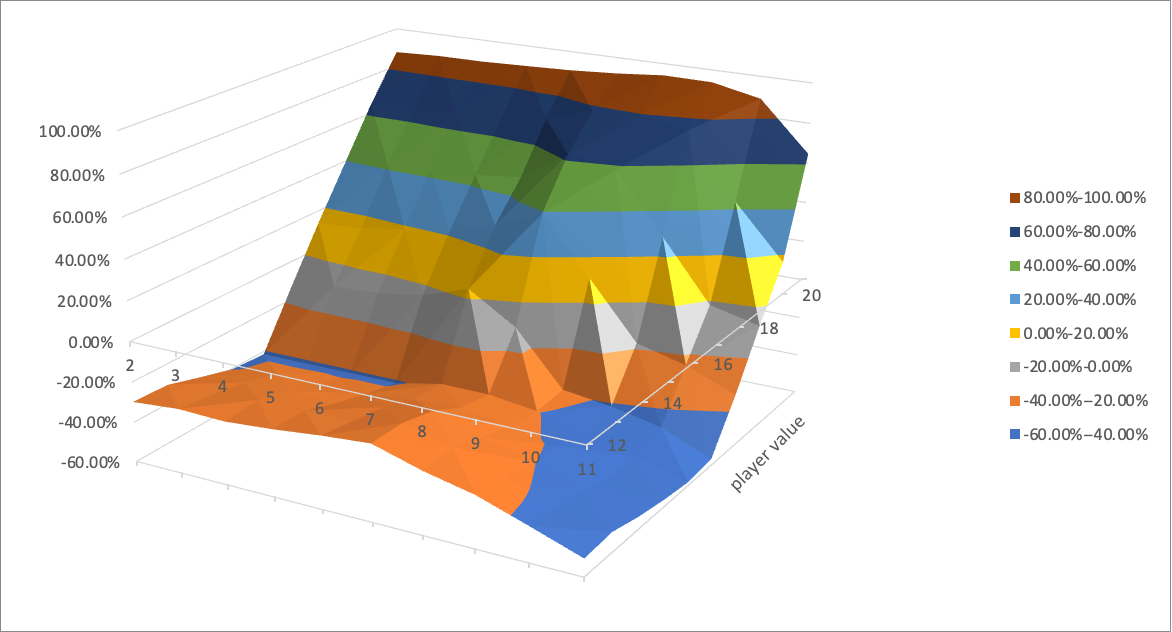

In [215]:
min20_results = exploring_starts_eval("min20", HitUntilPolicy(min_value=20))
min20_avg_reward = sum([v["reward"] for v in min20_results.values()]) / sum([v["episodes"] for v in min20_results.values()])
print(f"{min20_avg_reward:.2%}")

evaluating min20...:   0%|          | 0/219700 [00:00<?, ?it/s]

-35.92%


### Optimized exploring starts

In [344]:
import math

In [473]:
class TrainablePolicy:

    @dataclass
    class StateActionInfo:
        observations: int = 0
        rewards: int = 0

        def update(self, reward: int):
            self.observations += 1
            self.rewards += reward

        def get_average_reward(self) -> float:
            if self.observations == 0:
                return 0.0
            return self.rewards / self.observations

    @staticmethod
    def _init_qvalues():
        result = collections.defaultdict(lambda: collections.defaultdict(lambda: TrainablePolicy.StateActionInfo()))
        for dealer_value in range(13):
            for player_value in range(21):
                for usable_ace in [True, False]:
                    state_key = (dealer_value, player_value, usable_ace)
                    if player_value >= 20:
                        result[state_key]['hit'] = TrainablePolicy.StateActionInfo(1, 0)
                        result[state_key]['stick'] = TrainablePolicy.StateActionInfo(1, 1)
                    else:
                        result[state_key]['hit'] = TrainablePolicy.StateActionInfo(1, 1)
                        result[state_key]['stick'] = TrainablePolicy.StateActionInfo(1, 0)
        return result

    def __init__(self):
        self.qvalues = self._init_qvalues()

    def get_state_info(self, game: Game):
        return self.qvalues[get_state_key(game)]
    
    def get_action_info(self, game: Game, action: str):
        return self.get_state_info(game)[action]
    
    def get_action_value(self, game: Game, action: str):
        return self.get_action_info(game, action).get_average_reward()
    
    def get_hit_value(self, game: Game):
        return self.get_action_value(game, 'hit')
    
    def get_stick_value(self, game: Game):
        return self.get_action_value(game, 'hit')
    
    def get_optimal_action(self, game: Game):
        optimal_value = -math.inf
        optimal_action = None
        for action, info in self.get_state_info(game).items():
            if optimal_value < info.get_average_reward():
                optimal_value = info.get_average_reward()
                optimal_action = action
        return optimal_action, optimal_value
    
    def play(self, game: Game):
        actions = []
        while not game.is_finished():
            state_key = get_state_key(game)
            action, _ = self.get_optimal_action(game)
            if action == 'hit':
                game.hit()
                actions.append((state_key, 'hit'))
            else:
                game.stick()
                actions.append((state_key, 'stick'))

        for state_key, action in actions:
            self.learn(state_key, action, game.get_reward())

    def learn(self, state_key: Any, action: str, reward: float):
        self.qvalues[state_key][action].update(reward)
        

In [474]:
# policy = TrainablePolicy()

In [475]:
# game = Game(seed=1829427999, dealer_card=Card(9), player_hand=Hand(Card(5), Card(11)))
# game

In [476]:
# policy.get_state_info(game)

In [477]:
# policy.play(game)

In [478]:
# game = Game(seed=1829427999, dealer_card=Card(9), player_hand=Hand(Card(5), Card(11)))
# policy.get_state_info(game)

In [489]:
policy_stats = {}

In [490]:
exp_name = "mc-min20-100"
policy_stats[exp_name] = exploring_starts_eval(exp_name, policy=TrainablePolicy(), iterations=100)
avg_reward = sum([v["reward"] for v in policy_stats[exp_name].values()]) / sum([v["episodes"] for v in policy_stats[exp_name].values()])
print(f"{avg_reward:.2%}")

evaluating mc-min20-100...:   0%|          | 0/219700 [00:00<?, ?it/s]

-8.32%


In [491]:
exp_name = "mc-min20-500"
policy_stats[exp_name] = exploring_starts_eval(exp_name, policy=TrainablePolicy(), iterations=500)
avg_reward = sum([v["reward"] for v in policy_stats[exp_name].values()]) / sum([v["episodes"] for v in policy_stats[exp_name].values()])
print(f"{avg_reward:.2%}")

evaluating mc-min20-500...:   0%|          | 0/1098500 [00:00<?, ?it/s]

-8.07%


In [492]:
results = []
for policy_name, stats in policy_stats.items():
    for (dv, pv, ua), info in stats.items():
        results.append({
            'policy': policy_name, 
            'dealer_value': dv, 
            'player_value': pv, 
            'usable_ace': bool(ua), 
            'episodes': info['episodes'], 
            'reward': info['reward']
        })

results = pd.DataFrame(results)
results.to_csv("./chapter-05-blackjack-results-mc.tsv", sep="\t", index=False)
results

,policy,dealer_value,player_value,usable_ace,episodes,reward
0,mc-min20-100,2,4,False,100,-19
1,mc-min20-100,2,5,False,200,-32
2,mc-min20-100,2,6,False,300,-72
3,mc-min20-100,2,7,False,400,-33
4,mc-min20-100,2,8,False,500,-32
...,...,...,...,...,...,...
535,mc-min20-500,11,19,False,4000,-376
536,mc-min20-500,11,20,True,1000,166
537,mc-min20-500,11,20,False,8000,1350
538,mc-min20-500,11,21,True,4000,2758
